In [1]:
import numpy as np
import pandas as pd
import os
import pprint
import sklearn
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
import matplotlib
from os import listdir
import seaborn as sns
import scipy
import sys
import pickle
import miceforest as mf
warnings.filterwarnings("ignore")
import functools
from functools import reduce
from mc4.algorithm import mc4_aggregator
from copy import deepcopy

import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import missingpy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, log_loss, roc_auc_score
from collections import Counter
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import NearMiss
from collections import Counter

import shap
import matplotlib.pyplot as plt
import statsmodels.api as sm
from torch.utils.data import Dataset, DataLoader

In [2]:
rs = 42

In [3]:
import random

def _init_fn(worker_id):
    np.random.seed(int(rs))
    
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_torch()

In [4]:
# Undersample Test Set
test_under_sampler = 0
do_class_weight = 1

# Undersample Train Set
do_smote = 0
do_random_under_sampler = 0
do_random_over_sampler = 0
do_tomek_links = 0
do_near_miss = 0

In [5]:
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

In [6]:
os.chdir('..')

In [7]:
prediction_window = ""

In [8]:
data_directory = 'Sepsis Data/'
prediction_directory = 'sepsis/'

data_files = find_csv_filenames(data_directory+prediction_directory)

hosps = [x.replace('.csv', '') for x in data_files]

In [9]:
model_directory = 'Sepsis Models/' + prediction_window + '/Pytorch MLP/'

#### Loading Cleaned Data

In [10]:
def get_features_diag(data):
    features = list(data_dictionary[hosp])
    features.remove(list(data_dictionary[hosp])[-1])
    AKI_diag = list(data_dictionary[hosp])[-1]
    return features, AKI_diag

def do_training_modifications(X_train, y_train):
    if do_smote:
        oversample = SMOTE(random_state=rs)
        X_train, y_train = oversample.fit_resample(X_train, y_train)
    if do_random_under_sampler:
        rus = RandomUnderSampler(replacement=True, random_state=rs)
        X_train, y_train = rus.fit_resample(X_train, y_train)
    if do_random_over_sampler:
        ros = RandomOverSampler(random_state=rs)
        X_train, y_train = ros.fit_resample(X_train, y_train)
    if do_tomek_links:
        tl = TomekLinks(random_state=rs)
        X_train, y_train = tl.fit_resample(X_train, y_train)
    if do_near_miss:
        nm = NearMiss(random_state=rs)
        X_train, y_train = nm.fit_resample(X_train, y_train)  
    return X_train, y_train

def normalize_data(data_dictionary, hosp):
    df = deepcopy(data_dictionary[hosp])
    demographic_index = list(df).index('is_female')
    medical_signs = list(df)[:demographic_index]
    medication_index = list(df).index('ACETAMIN')
    medications = list(df)[medication_index:len(list(data))-1]
    demographic_binary = ['is_female', 'race_black', 'race_hispanic', 'race_asian', 
                        'race_other', 'electivesurgery']
    binary_features = medications + demographic_binary
    continuous_features = medical_signs + ['age', 'BMI']

    df[continuous_features] = (df[continuous_features]-df[continuous_features].mean())/df[continuous_features].std()
    df[binary_features] = df[binary_features].replace([0],-1)
    return df

In [11]:
temp_data_dictionary = dict.fromkeys(hosps)
data_dictionary = dict.fromkeys(hosps)
missing_dictionary = dict.fromkeys(hosps)

In [12]:
for hosp in data_dictionary:
    file = str(hosp) + '.csv'
    data = pd.read_csv(data_directory + prediction_directory + "cleaned/" + file)
    data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
    data_dictionary[hosp] = data

In [13]:
for hosp in data_dictionary:
    data_dictionary[hosp] = normalize_data(data_dictionary, hosp)

#### Functions for Model Training and Validation

In [14]:
class MLP(nn.Module):
    def __init__(self,input_shape):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(input_shape,10)
        self.fc2 = nn.Linear(10,1)
    
    def forward(self,x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x
    
    def fit(self, X_train, y_train, epochs=200, lr=0.001):
        X_train = X_train.values
        y_train = y_train.values
        class_weights = sklearn.utils.compute_class_weight('balanced', classes=np.unique(np.squeeze(y_train)),
                                                           y=np.squeeze(y_train))
        trainset = dataset(X_train, y_train)
        train_loader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers = 0, worker_init_fn=_init_fn)
        criterion = nn.BCELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=lr)
        self.train_model(train_loader, criterion, optimizer, epochs, class_weights)
        return self
    
    def predict_prob(self, X):
        with torch.no_grad():
            return np.array(self(torch.tensor(X,dtype=torch.float32)).flatten())
        
    def get_predictions(self, X_test):
        with torch.no_grad():
            predicted = self(torch.tensor(X_test,dtype=torch.float32))
            predictions_one_encoded = predicted.reshape(-1).detach().numpy().round()
            return np.array(predicted).flatten(), predictions_one_encoded
        
    def train_model(self, train_loader, criterion, optimizer, epochs, class_weights):
        for i in range(epochs):
            for j,(x_train,y_train) in enumerate(train_loader):
                #calculate output
                output = self(x_train)
                # set criterion weight
                batch_class_weights = y_train.clone().detach()
                batch_class_weights[batch_class_weights == 0] = class_weights[0]
                batch_class_weights[batch_class_weights == 1] = class_weights[1]
                criterion.weight = batch_class_weights.reshape(-1,1)
                #calculate loss
                loss = criterion(output,y_train.reshape(-1,1))
                #backprop
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

In [15]:
def evaluate_model_optim(model, y_test, X_test, print_dist=False):
    y_test = y_test.values
    probs, predictions = model.get_predictions(X_test.values)
    y_pred_coded = predictions
    probs = probs.flatten()
    if print_dist == True:
        print("Distribution of Test Predictions")
        pred_class_distribution(y_test, y_pred_coded)
        print("###########")
    metric=[]
    metric.append(['accuracy',np.round(accuracy_score(y_test,y_pred_coded), 3)])
    roc_score = np.round(roc_auc_score(y_test, probs), 3)
    metric.append(['roc',np.round(roc_score, 3)])
    metric.append(['precision',np.round(precision_score(y_test,y_pred_coded), 3)])
    metric.append(['recall',np.round(recall_score(y_test,y_pred_coded), 3)])
    return metric

def pred_class_distribution(y_test, y_pred_coded):
    zero_wrong, zero_right, one_wrong, one_right = [0] * 4
    for i in range(0, len(y_pred_coded)):
        if y_test[i] == 0:
            if y_pred_coded[i] == 0:
                zero_right += 1
            else:
                zero_wrong += 1
        if y_test[i] == 1:
            if y_pred_coded[i] == 1:
                one_right += 1
            else:
                one_wrong += 1
    print("Number of 0 Class Predictions Right: " + str(zero_right))
    print("Number of 0 Class Predictions Wrong: " + str(zero_wrong))
    print("Number of 1 Class Predictions Right: " + str(one_right))
    print("Number of 1 Class Predictions Wrong: " + str(one_wrong))

In [16]:
def load_cv_models(hosp):
    cv_models = []
    for i in range(0, 5):
        fold = i + 1
        filename = model_directory + hosp + '_CV' + str(fold) + ".pckl"
        model = pickle.load(open(filename, 'rb'))
        cv_models.append(model)
    return cv_models

In [17]:
def get_cross_validated_scores_race(hosps, strat_feature, model_name='Agg', return_positive=1):
    splits = 5
    cv = sklearn.model_selection.StratifiedKFold(n_splits=splits,shuffle=True, random_state=rs)
    
    all_accs = []
    all_aucs = []
    all_precs = []
    all_recs = []
    all_macro_predictions = []
    all_macro_test = []
    
    models = load_cv_models('Agg')
    
    for split_count in range(splits):    
        X_training_dictionary = {}
        X_testing_dictionary = {}
        y_training_dictionary = {}
        y_testing_dictionary = {}

        empty_flag = 0
        
        for hosp in data_dictionary:
            data = data_dictionary[hosp]
            data = data[data[strat_feature] == return_positive]
            features, AKI_diag = get_features_diag(data)
            X = data[features]
            Y = data[AKI_diag]
            if not X.empty:
                train, test = get_fold_info(split_count, cv.split(X, Y))
                X_training_dictionary[hosp] = X.iloc[train]
                X_testing_dictionary[hosp] = X.iloc[test]
                y_training_dictionary[hosp] = Y.iloc[train]
                y_testing_dictionary[hosp] = Y.iloc[test]
        
        accs = []
        aucs = []
        precs = []
        recs = []
        macro_predictions = []
        macro_test = []
        
        model = models[split_count]
        
        for hosp in X_testing_dictionary:
            probs, y_pred_coded = model.get_predictions(X_testing_dictionary[hosp].values)
            fpr, tpr, t = sklearn.metrics.roc_curve(y_testing_dictionary[hosp].values, probs)
            acc = accuracy_score(y_testing_dictionary[hosp].values, y_pred_coded)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            prec = precision_score(y_testing_dictionary[hosp].values,y_pred_coded)
            rec = recall_score(y_testing_dictionary[hosp].values,y_pred_coded)
            aucs.append(roc_auc), accs.append(acc), precs.append(prec), recs.append(rec)
            macro_predictions.append(probs)
            macro_test.append(y_testing_dictionary[hosp].values)

        all_accs.append(accs), all_aucs.append(aucs), all_precs.append(precs), all_recs.append(recs)
        all_macro_predictions.append(np.array(macro_predictions)), all_macro_test.append(np.array(macro_test))
    
    all_accs = np.array(all_accs)
    all_aucs = np.array(all_aucs)
    all_precs = np.array(all_precs)
    all_recs = np.array(all_recs)
    all_macro_predictions = np.array(all_macro_predictions)
    all_macro_test = np.array(all_macro_test)
    
    available_hosps = X_testing_dictionary.keys()
    
    metrics_dictionary = dict.fromkeys(available_hosps)
    stds_dictionary = dict.fromkeys(available_hosps)
    roc_info_dictionary = dict.fromkeys(available_hosps)
    
    for i, hosp in enumerate(available_hosps):
        metric = []
        stds = []        
        mean_acc = np.round(np.nanmean(all_accs[:, i]), 3)
        mean_auc = np.round(np.nanmean(all_aucs[:, i]), 3)
        mean_prec = np.round(np.nanmean(all_precs[:, i]), 3)
        mean_rec = np.round(np.nanmean(all_recs[:, i]), 3)
        metric.append(['accuracy', mean_acc]), metric.append(['roc', mean_auc])
        metric.append(['prec', mean_prec]), metric.append(['rec', mean_rec])
        std_acc = np.round(np.nanstd(all_accs[:, i]), 3)
        std_auc = np.round(np.nanstd(all_aucs[:, i]), 3)
        std_prec = np.round(np.nanstd(all_precs[:, i]), 3)
        std_rec = np.round(np.nanstd(all_recs[:, i]), 3)
        stds.append(['accuracy', std_acc]), stds.append(['roc', std_auc])
        stds.append(['prec', std_prec]), stds.append(['rec', std_rec])
        metrics_dictionary[hosp] = metric
        stds_dictionary[hosp] = stds
        
        roc_info = []
        all_predictions = np.concatenate(all_macro_predictions[:, i])
        all_test = np.concatenate(all_macro_test[:, i])
        fpr, tpr, t = sklearn.metrics.roc_curve(all_test, all_predictions)
        roc_info = [fpr, tpr, t]
        roc_info_dictionary[hosp] = roc_info
    
    return metrics_dictionary, stds_dictionary, roc_info_dictionary


def get_fold_info(split_count, gen):
    j = 0
    for train, test in gen:
        train = train
        test = test
        if split_count == j:
            break
        j += 1
    return train, test

In [18]:
def display_metrics(metrics, stand_dev = None):
    if stand_dev is None:
        print("Accuracy: {}".format(metrics[0][1]))
        print("AUC: {}".format(metrics[1][1]))
        print("Precision: {}".format(metrics[2][1]))
        print("Recall: {}".format(metrics[3][1]))
    else:
        s_acc = str(metrics[0][1]) + " ± " + str(stand_dev[0][1])
        s_auc = str(metrics[1][1]) + " ± " + str(stand_dev[1][1])
        s_prec = str(metrics[2][1]) + " ± " + str(stand_dev[2][1])
        s_rec = str(metrics[3][1]) + " ± " + str(stand_dev[3][1])
        print("Accuracy: " + s_acc)
        print("AUC: " + s_auc)
        print("Precision: " + s_prec)
        print("Recall: " + s_rec)

#### Aggregated Model Performances by Race

In [19]:
agg_data = pd.concat(data_dictionary.values())

features, AKI_diag = get_features_diag(agg_data)
X = agg_data[features]
Y = agg_data[AKI_diag]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=rs)

strat_feature = 'NITROGLYCERIN'
black_metrics_dictionary, black_stds_dictionary, black_roc_info_dictionary = get_cross_validated_scores_race(hosps, 
                                                                                           strat_feature, 
                                                                                           model_name='Agg', 
                                                                                           return_positive=1)

nonblack_metrics_dictionary, nonblack_stds_dictionary, nonblack_roc_info_dictionary = get_cross_validated_scores_race(hosps, 
                                                                                           strat_feature, 
                                                                                           model_name='Agg', 
                                                                                           return_positive=-1)

In [20]:
# for hosp in hosps:
#     print("Performance of Hosp {}:".format(hosp))
#     display_metrics(black_metrics_dictionary[hosp], stand_dev = black_stds_dictionary[hosp])
#     print("\n")

In [21]:
# for hosp in hosps:
#     print("Performance of Hosp {}:".format(hosp))
#     display_metrics(nonblack_metrics_dictionary[hosp], stand_dev = nonblack_stds_dictionary[hosp])
#     print("\n")

#### Plotting Stratified Performances for Pooled Model

In [22]:
channel = ['Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', 
          'Positive', 'Negative', 'Positive', 'Negative', 'Positive', 'Negative', ]
average_auc = []
std_auc = []
for hosp in hosps:
    average_auc.append(black_metrics_dictionary[hosp][1][1])
    average_auc.append(nonblack_metrics_dictionary[hosp][1][1])
    std_auc.append(black_stds_dictionary[hosp][1][1])
    std_auc.append(nonblack_stds_dictionary[hosp][1][1])

In [23]:
conc = np.repeat(hosps,2)
a = list(set(conc))
conc2 = [a.index(x) for x in conc]
conc2.sort()

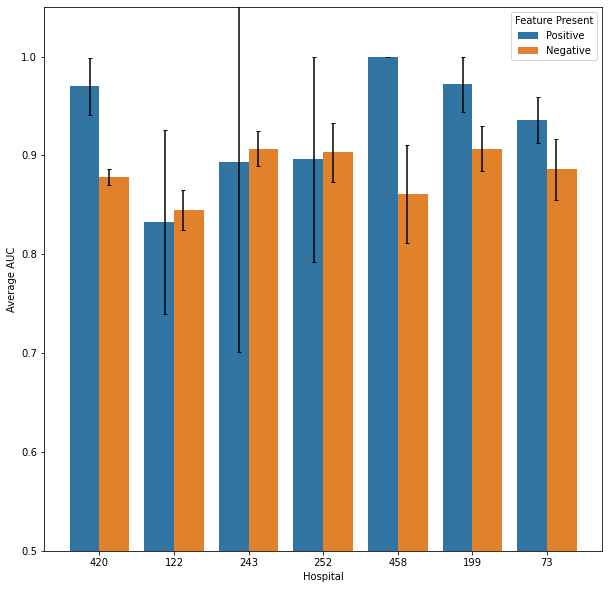

In [24]:
df = pd.DataFrame({"Feature Present": channel,
                  "Average AUC": average_auc,
                  "sd" : std_auc,
                  "Hospital": conc})

order = hosps
plt.figure(figsize=(10,10))
plt.ylim(0.5, 1.05)
sns.barplot(x="Hospital", y="Average AUC", hue="Feature Present", data=df, ci=None, 
            order=order)

width = .25
add = [-0.5*width, 0.5*width, -0.5*width, 0.5*width, -0.5*width, 0.5*width, -0.5*width, 0.5*width,
      -0.5*width, 0.5*width, -0.5*width, 0.5*width, -0.5*width, 0.5*width,]
x = np.array(conc2)+np.array(add)

plt.errorbar(x = x, y = df['Average AUC'],
            yerr=df['sd'], fmt='none', c= 'black', capsize = 2)
plt.show()